Part 1 contains information about:
1. Merging of the tables
2. Data quality checks
3. EDA -- pattern in regard with the target variable

In [5]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
#  load the two datasets
campaign_df = pd.read_csv("../Datasets/Campaign.csv", sep=",", header=0)
mortgage_df = pd.read_csv("../Datasets/Mortgage.csv", sep=",", header=0)

campaign_df.head(3)

,participant_id,name_title,first_name,last_name,age,postcode,marital_status,education,job_title,occupation_level,education_num,familiarity_FB,view_FB,interested_insurance,company_email,created_account
0,8.997000e+12,Mr.,Dale,Coles,39,EH4 9FL,Never-married,Bachelors,Furniture conservator/restorer,1,17,7,9,0,jrhodes@jones.com,No
1,2.764970e+12,NaN,Joel,Allen,50,LS5H 0JG,Married-civ-spouse,Bachelors,"Administrator, sports",4,17,9,6,1,william32@carey.com,No
2,8.454880e+12,Mr.,Craig,Davis,38,EH8W 2QJ,Divorced,HS-grad,Armed forces training and education officer,12,12,5,4,1,smithvanessa@coles.org,No


In [4]:
# check for duplicate values and NAs
def simple_checks(df):
    """Run sumple checks on the dataset
    """
    n_duplicates = df.shape[0] - df.drop_duplicates().shape[0]
    print(f"Campaign data contain {n_duplicates} duplicate values.")

    for col in df.columns:
        n_nulls = df[col].isnull().sum()
        n_distinct = df[col].nunique()
        print(f"Value {col} contains {n_nulls} null values and {n_distinct} distinct values.")

simple_checks(campaign_df)
print("--- --- --- --- ---")
simple_checks(mortgage_df)

Campaign data contain 0 duplicate values.
Value participant_id contains 0 null values and 31639 distinct values.
Value name_title contains 12201 null values and 5 distinct values.
Value first_name contains 0 null values and 182 distinct values.
Value last_name contains 0 null values and 500 distinct values.
Value age contains 0 null values and 73 distinct values.
Value postcode contains 0 null values and 31398 distinct values.
Value marital_status contains 0 null values and 7 distinct values.
Value education contains 0 null values and 16 distinct values.
Value job_title contains 0 null values and 691 distinct values.
Value occupation_level contains 0 null values and 20 distinct values.
Value education_num contains 0 null values and 16 distinct values.
Value familiarity_FB contains 0 null values and 10 distinct values.
Value view_FB contains 0 null values and 10 distinct values.
Value interested_insurance contains 0 null values and 2 distinct values.
Value company_email contains 0 null 

Join the data

In [7]:
Campaign_copy_df = campaign_df.copy()

In [8]:
# approach 1 -- full name
full_names = Campaign_copy_df["name_title"].fillna("") + " " + Campaign_copy_df["first_name"] + " " + Campaign_copy_df["last_name"]
full_names = [name.strip() for name in full_names]
Campaign_copy_df = Campaign_copy_df.assign(full_name=full_names)

n_unique_names = Campaign_copy_df["full_name"].nunique()
print(f"The campaign data contains {n_unique_names} unique full names. That accounts for {round(n_unique_names/Campaign_copy_df.shape[0]*100, 2)}% of all entries in the campaign dataset")

Campaign_copy_df\
    .groupby(["full_name"])\
    ["full_name"].count()\
    .rename("name_count")\
    .reset_index()\
    .sort_values("name_count")\
    .tail(4)

The campaign data contains 28942 unique full names. That accounts for 90.27% of all entries in the campaign dataset


,full_name,name_count
27515,Russell Smith,5
27332,Ronald Williams,6
18381,Mr. Mohammad Jones,6
7446,Lawrence Jones,7


In [11]:
# approach 2 -- full name + age
names_w_age = list(Campaign_copy_df["full_name"] + " - " + Campaign_copy_df["age"].astype(str))
Campaign_copy_df['names_w_age'] = names_w_age

Campaign_copy_df\
    .groupby(["names_w_age"])\
    ["participant_id"].count()\
    .reset_index()\
    .sort_values("participant_id")\
    .tail(4)

,names_w_age,participant_id
15878,Mr. Donald Ward - 45,2
12664,Mohammed Davies - 32,2
2295,Colin Smith - 41,2
17173,Mr. Graeme Smith - 21,3


In [14]:
# approach 3 -- full name + age + location
# since name and age are not enough to define a unique customer identifier for the people that were targeted by the previous campaign
# we need to add information about the city each person recides
# this can be done with the aid of two python packages, namely pgeocode and geopy
# I will use the first one to find the coordinates of the location (pgeocode does not return a city name and accept a 3letter zip code)
# and the secord one (geopy) to consume the coordinates of the place and return a city name
import pgeocode
from geopy.geocoders import Nominatim

# initialize the Nominatim API
geolocator = Nominatim(user_agent="campaign_eda")
# set the country for pgeovode to Great Britain
nomi = pgeocode.Nominatim("GB")


# --- --- --- --- helper --- --- --- ---
def postcode_to_city_converter(post_code: str) -> str:
    """Takes as input any postal code in string format and returns the city name
    """
    # keep the first three letters of the postal code
    if len(post_code)>=3:
        three_letter_postcode = post_code[:3]
    else:
        # len(pos_code)<3
        raise ValueError("Postal Code needs to be at least 3 characters long.")

    # get the coordinates of the location of the postal code
    lat, lon = nomi.query_postal_code(three_letter_postcode)[["latitude", "longitude"]]
    coordinates = str(lat) + "," + str(lon)

    # extract the geopy geolocation
    geolocation = geolocator.reverse(coordinates)
    address = geolocation.raw["address"]

    # if city in address.keys(): address["city"]
    # if town in address.keys(): address["town"]
    # return the city name
    return address

# The following does not return Edinburg -- no city
postcode_to_city_converter("EH4 9FL")

{'house_number': '288',
 'road': 'Craigcrook Road',
 'neighbourhood': 'Craigcrook',
 'suburb': 'Blackhall',
 'county': 'City of Edinburgh',
 'state': 'Alba / Scotland',
 'postcode': 'EH4 7BA',
 'country': 'United Kingdom',
 'country_code': 'gb'}

In [15]:
# approach 4 -- row id as customer id
# since there are a few issues with the city locator from the geolocator python packages
# we can now assume that the two dataset have the row id as customer id and join them on that information
# this has been validates by viewing only, a variety of results
full_df = pd.concat([campaign_df, mortgage_df], axis=1, join="inner")

Data Quality

There are 0 missing values from the age column


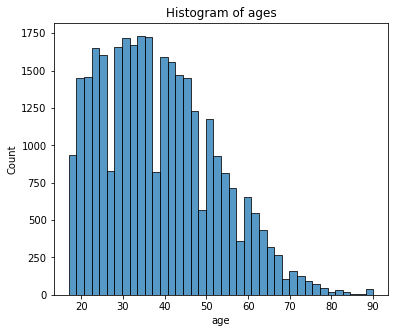

count    32060.000000
mean        38.564816
std         13.637532
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

In [16]:
# age of participant
n_missing = full_df[full_df["age"].isnull()].shape[0]
print(f"There are {n_missing} missing values from the age column")

plt.figure(figsize=(6, 5))
splot = sns.histplot(data=full_df, x="age", bins=40)
splot.set(xlabel="age",
          title="Histogram of ages")
plt.show()

# ages seem to follow a logical values -- they are in a range that works
full_df["age"].describe()

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_51836\4199968541.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_51836\4199968541.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


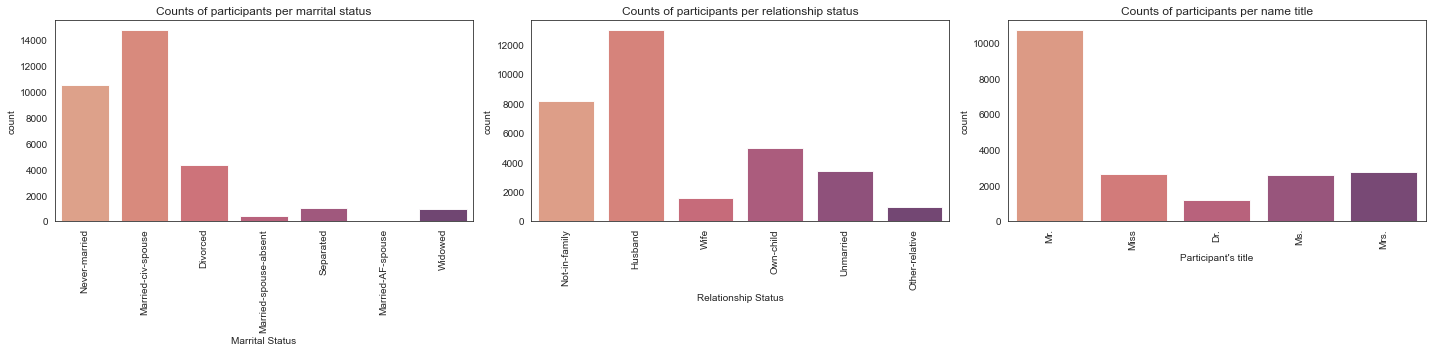

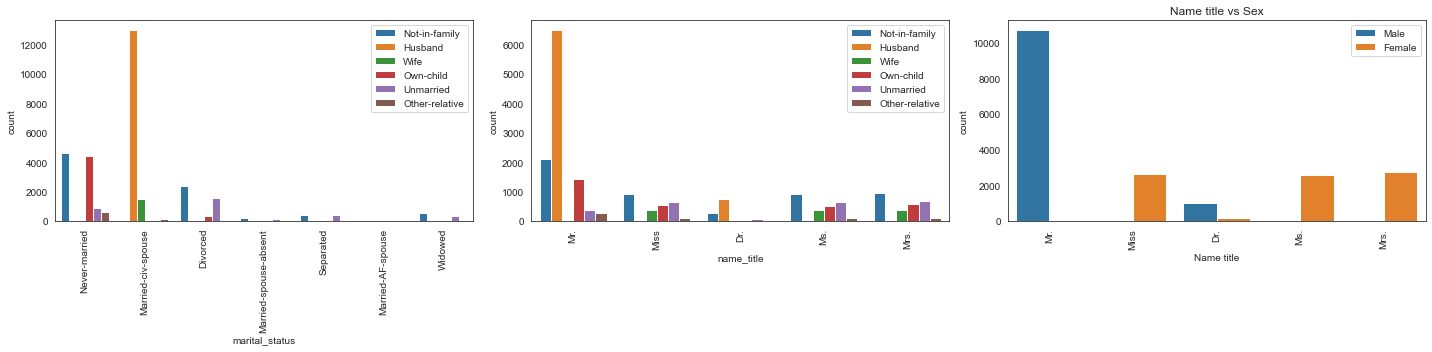

In [17]:
sns.set_style("white")
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

splot = sns.countplot(data=full_df, x="marital_status", palette="flare", alpha=0.9, ax=axes[0])
splot.set_xticklabels(labels=full_df[~full_df["marital_status"].isnull()]["marital_status"].unique(), rotation=90) 
splot.set(xlabel="Marrital Status",
          title="Counts of participants per marrital status")

splot = sns.countplot(data=full_df, x="relationship", palette="flare", alpha=0.9, ax=axes[1])
splot.set_xticklabels(labels=full_df[~full_df["relationship"].isnull()]["relationship"].unique(), rotation=90) 
splot.set(xlabel="Relationship Status",
          title="Counts of participants per relationship status")

splot = sns.countplot(data=full_df, x="name_title", palette="flare", alpha=0.9, ax=axes[2])
splot.set_xticklabels(labels=full_df[~full_df["name_title"].isnull()]["name_title"].unique(), rotation=90) 
splot.set(xlabel="Participant's title",
          title="Counts of participants per name title")

plt.tight_layout()
fig.show()


# check if the values are correct -- for example relationship husband should not be divorced marital status
# some pairs of values exist
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

splot = sns.countplot(data=full_df, x="marital_status", hue="relationship",ax=axes[0])
splot.set_xticklabels(labels=full_df[~full_df["marital_status"].isnull()]["marital_status"].unique(), rotation=90)
axes[0].legend(loc="upper right")

splot = sns.countplot(data=full_df, x="name_title", hue="relationship", ax=axes[1])
splot.set_xticklabels(labels=full_df[~full_df["name_title"].isnull()]["name_title"].unique(), rotation=90)
axes[1].legend(loc="upper right")

splot = sns.countplot(data=full_df, x="name_title", hue="sex", ax=axes[2])
splot.set_xticklabels(labels=full_df[~full_df["name_title"].isnull()]["name_title"].unique(), rotation=90)
splot.set(xlabel="Name title",
          title="Name title vs Sex")
axes[2].legend(loc="upper right")

plt.tight_layout()
fig.show()

In [18]:
# check if age and year/ weeks with current employer make sence
# a minimum age for someone to start legitimate work is 13 for part time and 16 for full time
# https://www.gov.uk/child-employment
min_start_work_age = (full_df["age"] - full_df["years_with_employer"]).min()
print(f"The minimum age that someone has started working in this dataset in {min_start_work_age} years.")

The minimum age that someone has started working in this dataset in 16 years.


C:\Users\Anastasia\AppData\Local\Temp\ipykernel_51836\1745798908.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


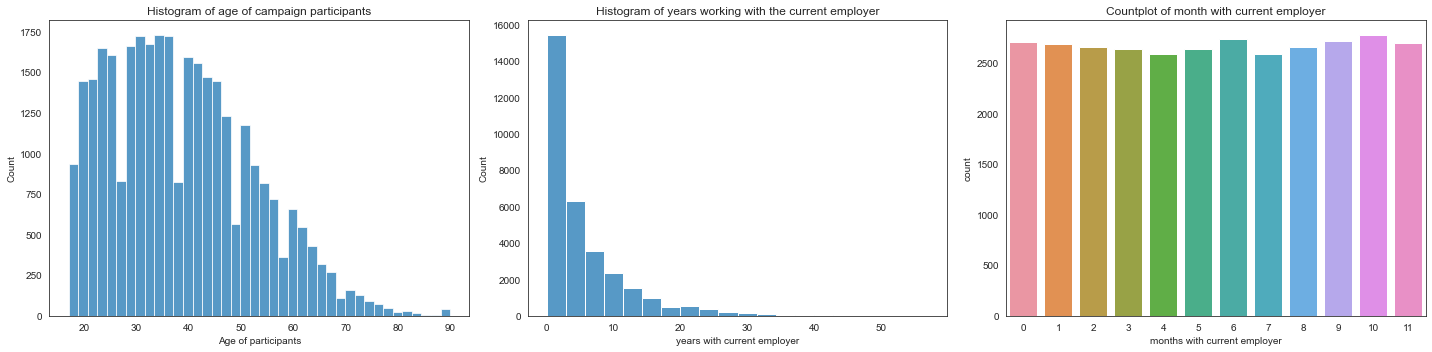

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

splot = sns.histplot(data=full_df, x="age", bins=40, ax=axes[0])
splot.set(title="Histogram of age of campaign participants",
          xlabel="Age of participants")

splot = sns.histplot(data=full_df, x="years_with_employer", bins=20, ax=axes[1])
splot.set(title="Histogram of years working with the current employer",
          xlabel="years with current employer")

splot = sns.countplot(data=full_df, x="months_with_employer", ax=axes[2])
splot.set(title = "Countplot of month with current employer",
          xlabel="months with current employer")

plt.tight_layout()
fig.show()

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_51836\664419154.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


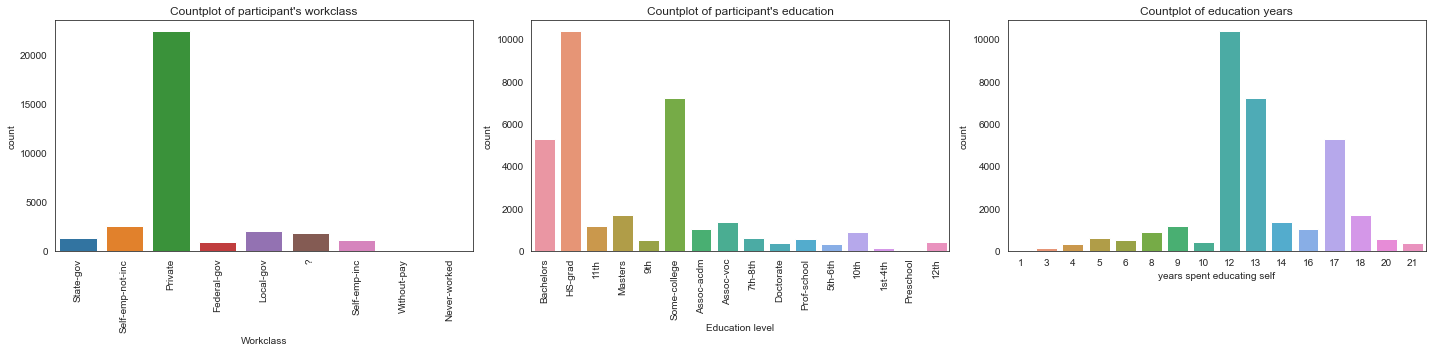

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

splot = sns.countplot(data=full_df, x="workclass", ax=axes[0])
splot.set_xticklabels(labels=full_df[~full_df["workclass"].isnull()]["workclass"].unique(), rotation=90)
splot.set(title="Countplot of participant's workclass",
          xlabel="Workclass")

splot = sns.countplot(data=full_df, x="education", ax=axes[1])
splot.set_xticklabels(labels=full_df[~full_df["education"].isnull()]["education"].unique(), rotation=90)
splot.set(title="Countplot of participant's education",
          xlabel="Education level")

splot = sns.countplot(data=full_df, x="education_num", ax=axes[2])
splot.set(title = "Countplot of education years",
          xlabel="years spent educating self")

plt.tight_layout()
fig.show()

In [21]:
# 1-1 mapping between education and education years
full_df\
    .groupby(["education", "education_num"])\
    ["participant_id"].count()\
    .reset_index()\
    .sort_values("education_num")

,education,education_num,participant_id
13,Preschool,1,48
3,1st-4th,3,165
4,5th-6th,4,328
5,7th-8th,5,634
6,9th,6,504
0,10th,8,919
1,11th,9,1159
2,12th,10,419
11,HS-grad,12,10347
15,Some-college,13,7190


C:\Users\Anastasia\AppData\Local\Temp\ipykernel_51836\3279822058.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


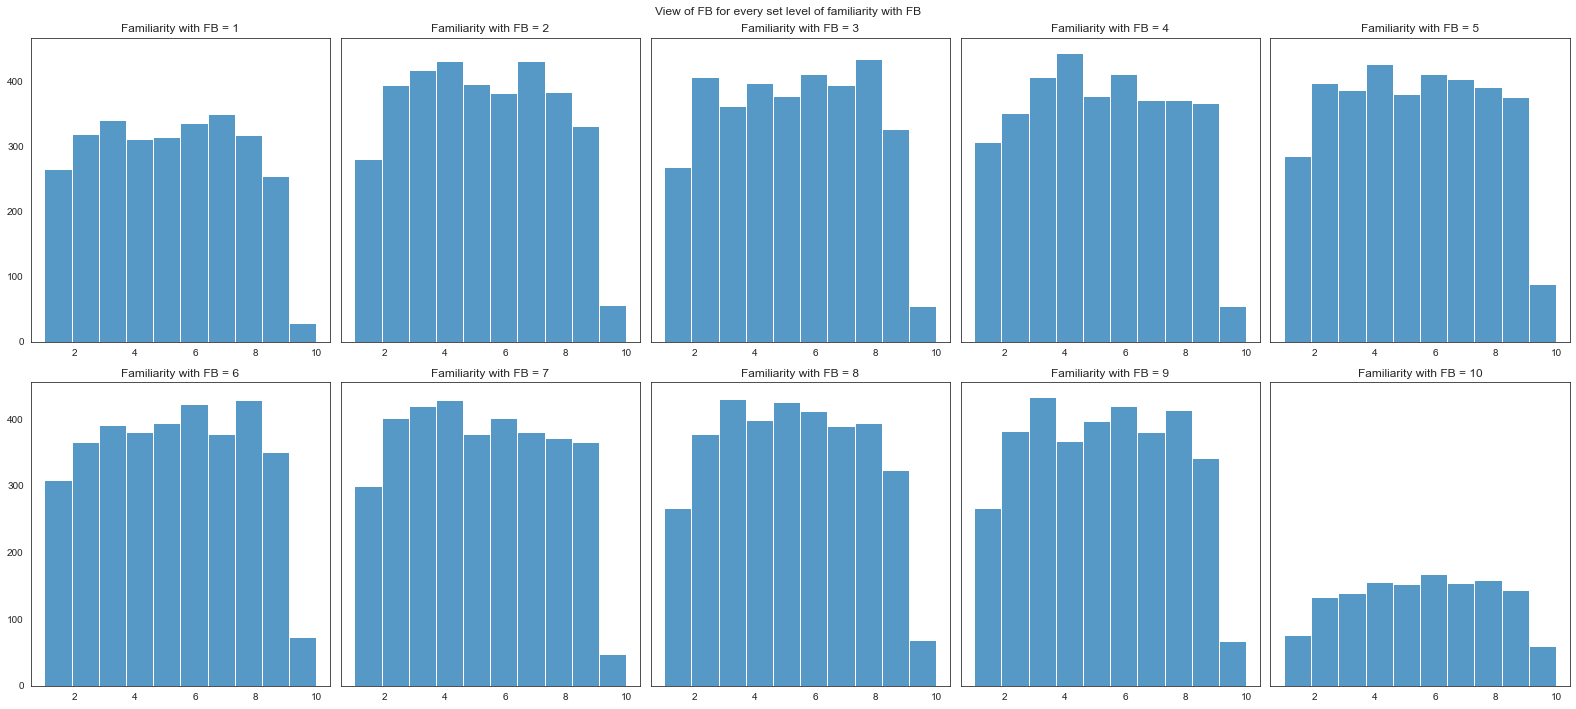

In [22]:
# how the view of Future Bank change with the level of familiarity
fig, axes = plt.subplots(2, 5, sharey="row", figsize=(22, 10))

j=0
for i in range(10):
    if (i!=0) & (i%5==0):
        j=1
    ax=axes[j][i%5]
    df = full_df[['familiarity_FB', 'view_FB']][full_df["familiarity_FB"]==i+1]
    splot = sns.histplot(df, x="view_FB", bins=10, ax=ax)
    splot.set(title=f"Familiarity with FB = {i+1}",
              xlabel="",
              ylabel="")

plt.suptitle("View of FB for every set level of familiarity with FB")
plt.tight_layout()
fig.show()

EDA

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_51836\724960631.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


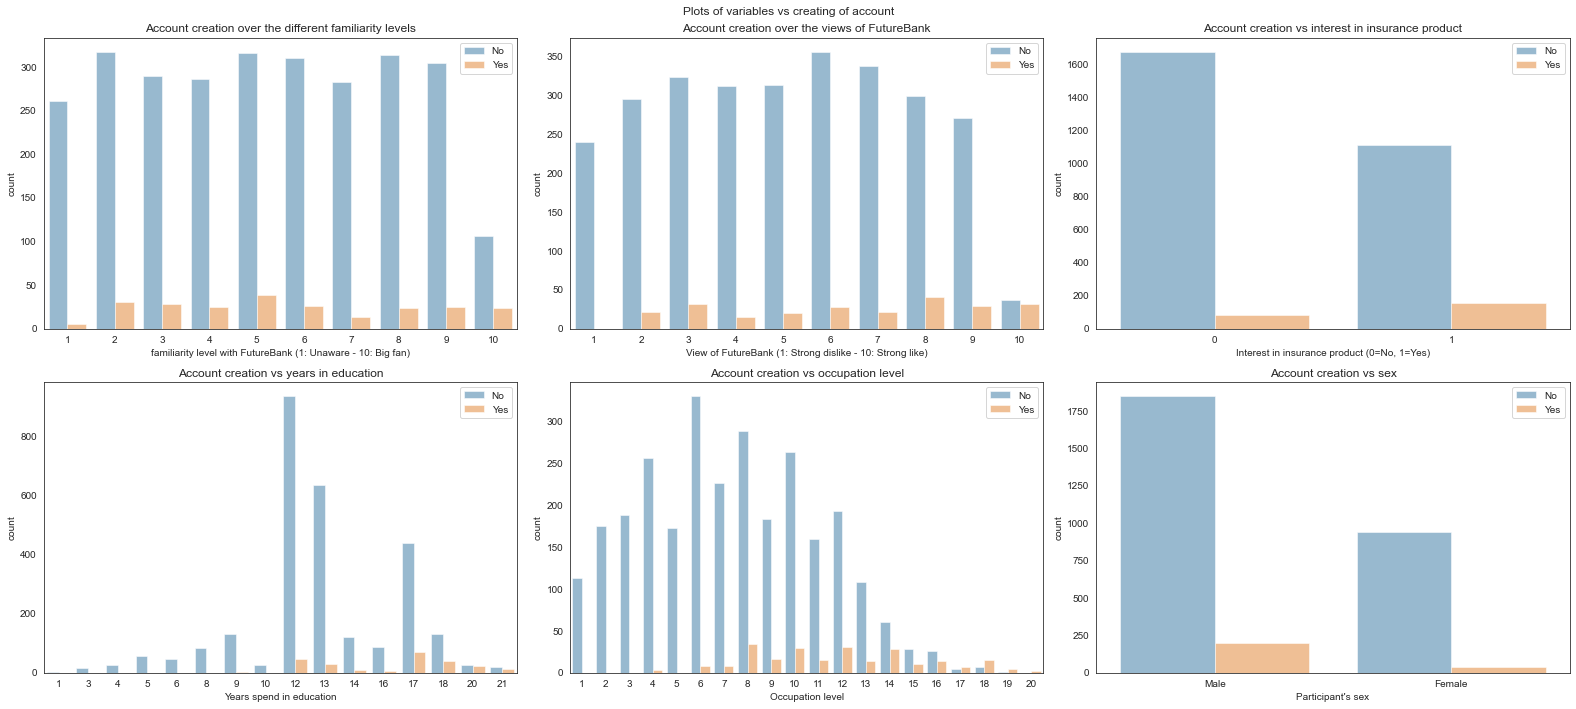

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(22, 10))

splot = sns.countplot(data=full_df, x="familiarity_FB", hue="created_account", alpha=0.5, ax=axes[0][0])
splot.set(xlabel="familiarity level with FutureBank (1: Unaware - 10: Big fan)",
          title="Account creation over the different familiarity levels")
axes[0][0].legend(loc="upper right")

splot = sns.countplot(data=full_df, x="view_FB", hue="created_account", alpha=0.5, ax=axes[0][1])
splot.set(xlabel="View of FutureBank (1: Strong dislike - 10: Strong like)",
          title="Account creation over the views of FutureBank")
axes[0][1].legend(loc="upper right")

splot = sns.countplot(data=full_df, x="interested_insurance", hue="created_account", alpha=0.5, ax=axes[0][2])
splot.set(xlabel="Interest in insurance product (0=No, 1=Yes)",
          title="Account creation vs interest in insurance product")
axes[0][2].legend(loc="upper right")

splot = sns.countplot(data=full_df, x="education_num", hue="created_account", alpha=0.5, ax=axes[1][0])
splot.set(xlabel="Years spend in education",
          title="Account creation vs years in education")
axes[1][0].legend(loc="upper right")

splot = sns.countplot(data=full_df, x="occupation_level", hue="created_account", alpha=0.5, ax=axes[1][1])
splot.set(xlabel="Occupation level",
          title="Account creation vs occupation level")
axes[1][1].legend(loc="upper right")

splot = sns.countplot(data=full_df, x="sex", hue="created_account", alpha=0.5, ax=axes[1][2])
splot.set(xlabel="Participant's sex",
          title="Account creation vs sex")
axes[1][2].legend(loc="upper right")

plt.suptitle("Plots of variables vs creating of account")
plt.tight_layout()
fig.show()

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_51836\3300435379.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


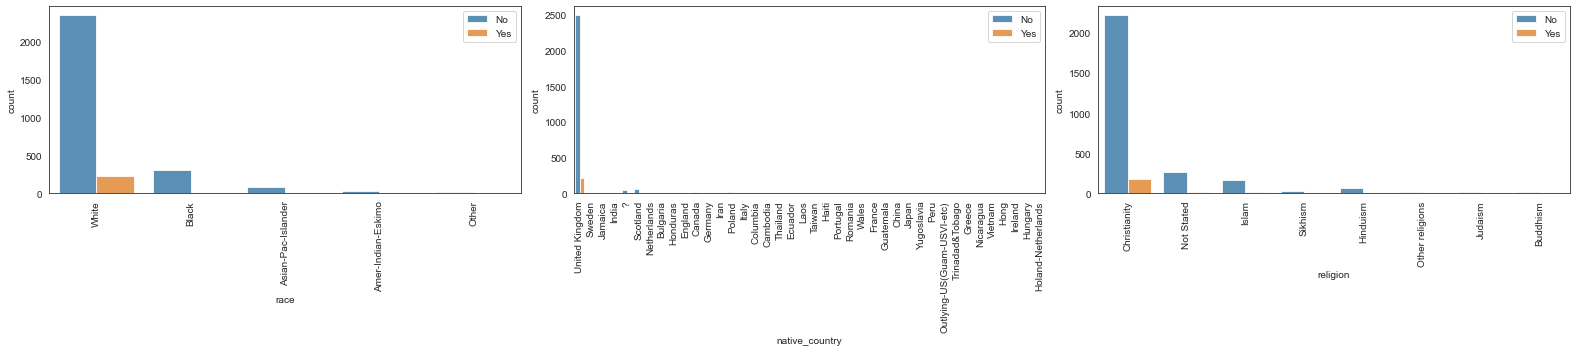

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5))

splot = sns.countplot(data=full_df, x="race", hue="created_account", alpha=0.8, ax=axes[0])
splot.set_xticklabels(labels=full_df[~full_df["race"].isnull()]["race"].unique(), rotation=90)
axes[0].legend(loc="upper right")

splot = sns.countplot(data=full_df, x="native_country", hue="created_account", alpha=0.8, ax=axes[1])
splot.set_xticklabels(labels=full_df[~full_df["native_country"].isnull()]["native_country"].unique(), rotation=90)
axes[1].legend(loc="upper right")

splot = sns.countplot(data=full_df, x="religion", hue="created_account", alpha=0.8, ax=axes[2])
splot.set_xticklabels(labels=full_df[~full_df["religion"].isnull()]["religion"].unique(), rotation=90)
axes[2].legend(loc="upper right")

plt.tight_layout()
fig.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_51836\1337757722.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


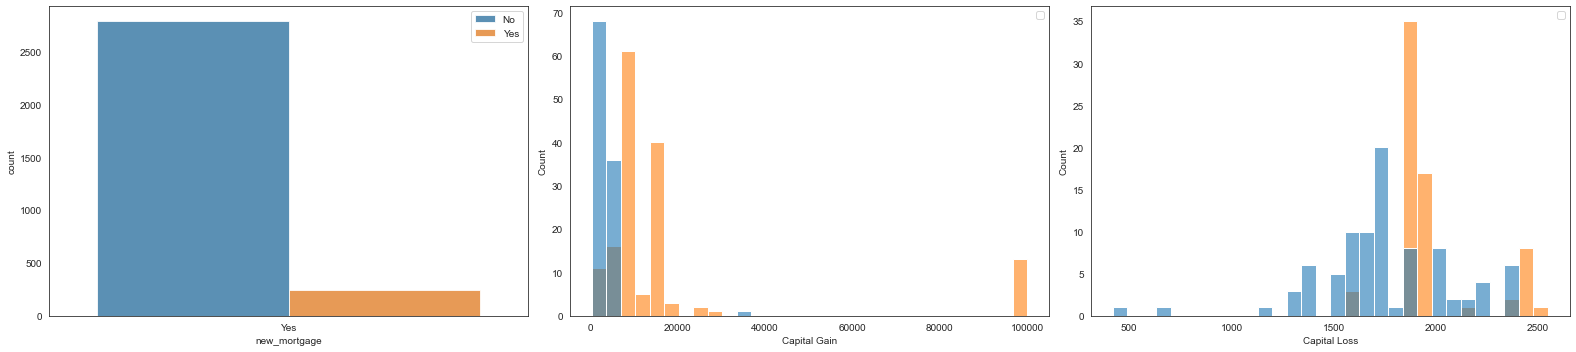

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(22, 5))

splot = sns.countplot(data=full_df, x="new_mortgage", hue="created_account", alpha=0.8, ax=axes[0])
axes[0].legend(loc="upper right")

# for capital gain and capital loss remove the values of 0 (property not sold?)
df = full_df[full_df["capital_gain"]!=0]
splot = sns.histplot(data=df, x="capital_gain", hue="created_account", alpha=0.6, bins=30, ax=axes[1])
splot.set(xlabel="Capital Gain")
axes[1].legend(loc="upper right")

df = full_df[full_df["capital_loss"]!=0]
splot = sns.histplot(data=df, x="capital_loss", hue="created_account", alpha=0.6, bins=30, ax=axes[2])
splot.set(xlabel="Capital Loss")
axes[2].legend(loc="upper right")

plt.tight_layout()
fig.show()

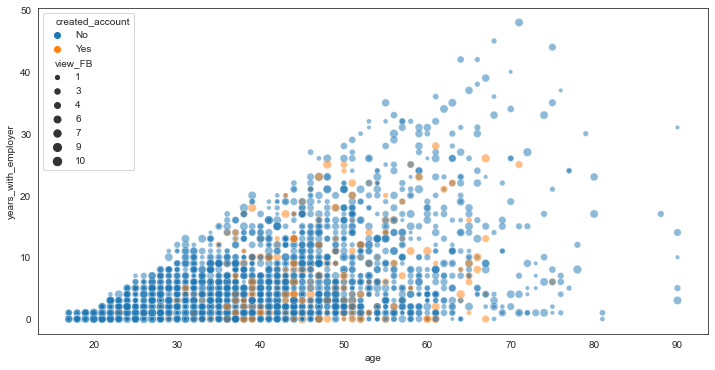

In [26]:
plt.figure(figsize=(12, 6))
splot = sns.scatterplot(data=full_df, x="age", y="years_with_employer", hue="created_account", size="view_FB", alpha=0.5)